In [3]:
!pip install -q accelerate torch


In [4]:
!pip install -U scikit-learn

In [5]:
!pip install umap-learn


In [6]:
!pip install pandas

In [7]:
!pip install matplotlib


In [8]:
!pip install pandas matplotlib datashader bokeh holoviews scikit-image colorcet

### Import Libraries

In [9]:
import torch


In [10]:
import pandas as pd
from torch.utils.data import Dataset
import numpy as np
from tqdm import tqdm



MNISTDataset class

In [11]:
class MNISTDataset(Dataset):
    def __init__(self, data_df: pd.DataFrame, transform=None, is_test=False):
        super(MNISTDataset, self).__init__()
        dataset = []
        labels_positive = {}
        labels_negative = {}
        if is_test == False:
            for i in list(data_df.label.unique()):
                labels_positive[i] = data_df[data_df.label == i].to_numpy()
            for i in list(data_df.label.unique()):
                labels_negative[i] = data_df[data_df.label != i].to_numpy()
        for i,row in tqdm(data_df.iterrows(), total=len(data_df)):
            data = row.to_numpy()
            if is_test:
                label = -1
                first = data.reshape(28,28)
                second = -1
                dis = -1
            else:
                label = data[0]
                first = data[1:].reshape(28,28)
                if np.random.randint(0,2) == 0:
                    second = labels_positive[label][np.random.randint(0, len(labels_positive[label]))]

                else:
                    second = labels_negative[label][np.random.randint(0, len(labels_negative[label]))]

                dis = 1.0 if second[0] == label else 0.0
                second = second[1:].reshape(28,28)
            if transform is not None:
                first = transform(first.astype(np.float32))
                if second != -1:
                    second = transform(second.astype(np.float32))

            dataset.append((first, second, dis, label))

        self.dataset = dataset
        self.transform = transform
        self.is_test = is_test
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self,i):
        return self.dataset[i]

In [12]:
import warnings 
warnings.filterwarnings('ignore')

In [13]:
from torch import nn, optim
from torch.utils.data import dataloader
from torchvision import transforms, datasets
from torchvision.datasets import MNIST
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
import umap
import umap.plot
import plotly.io as pio
pio.renderers.default = 'iframe'
from mnist_dataset import MNISTDataset

In [14]:
# pip install torchvision

# *Load MNIST Dataset*

In [15]:
from torch.utils.data import DataLoader

In [16]:
data = pd.read_csv("train.csv")


In [17]:
data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
val_count = 1000

In [19]:
len(data)

42000

In [20]:
dataset = MNISTDataset(data.iloc[:-val_count])

100%|█████████████████████████████████████████████████████████████████████████| 41000/41000 [00:01<00:00, 25783.18it/s]


In [21]:
len(dataset)


41000

In [22]:
default_transform = transforms.Compose([transforms.ToPILImage(),
                                        transforms.ToTensor(),
                                        transforms.Normalize(0.5, 0.5)])


## split the data into val and train

In [23]:
dataset = MNISTDataset(data.iloc[:-val_count], default_transform)
val_dataset = MNISTDataset(data.iloc[-val_count:], default_transform)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2139.70it/s]


In [24]:
len(dataset)

41000

In [25]:
len(val_dataset)

1000

# Setup our DataLoaders

#### create torch data loaders

In [26]:
trainLoader = DataLoader(
    dataset, 
    batch_size = 16,
    shuffle = True,
    pin_memory = True,
    num_workers = 2,
    prefetch_factor = 100
)
valLoader = DataLoader(val_dataset,
                       batch_size = 64,
                       shuffle = True,
                       pin_memory = True,
                       num_workers = 2,
                       prefetch_factor = 100
)


In [27]:
len(trainLoader)

2563

In [28]:
len(valLoader)  

16

16*64(batch_size) = 1024 ~ valLoader size

## Visualize datapoints

### function to display images with labels

In [29]:
def show_images(images, title = ''):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(9,3))
    for i in range(num_images):
        img = np.squeeze(images[i])
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
    fig.suptitle(title)
    plt.show()

#### visulaization

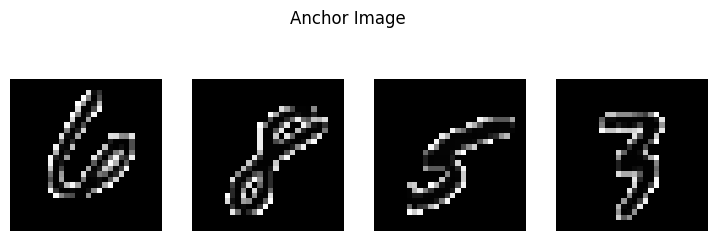

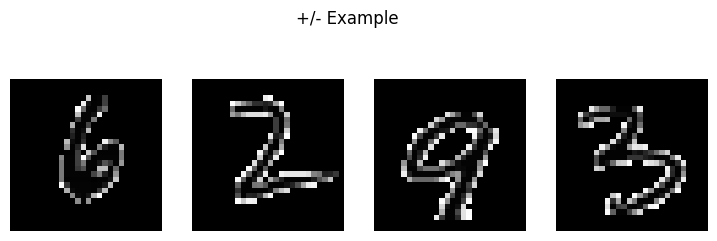

In [30]:
for batch_idx, (anchor_images, contrastive_images, distances, labels) in enumerate(trainLoader):
    anchor_images = anchor_images.numpy()
    contrastive_images = contrastive_images.numpy()
    labels = labels.numpy()

    show_images(anchor_images[:4], title='Anchor Image')
    show_images(contrastive_images[:4], title = '+/- Example')
    break

## Build a Neural Network Architecture

#### Propose a neural network architecture with two convolution layers and two fully connected layers

#### input to the network is an MNIST image and output is a 64 dimensional representation.

In [31]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,32,5),
            nn.BatchNorm2d(32), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2,2),stride=2),
            nn.Dropout(0.3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 5),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2,2),stride=2),
            nn.Dropout(0.3)
        )
        self.linear1 = nn.Sequential(
            nn.Linear(64*4*4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 64),
        )
    def forward(self, x):
        x = self.conv1(x) 
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        return x

## Contrastive Loss Function

In [32]:
class ContrastiveLoss(nn.Module):
    def __init__(self):
        super(ContrastiveLoss, self).__init__()
        self.similarity = nn.CosineSimilarity(dim = -1 ,eps=1e-7)
    def forward(self, anchor, contrastive, distance):
        score = self.similarity(anchor, contrastive)
        return nn.MSELoss()(score, distance)
        

### Define the Training Configuration

In [33]:
import torch

In [34]:
net = Network()
device = 'cpu'

if torch.cuda.is_available():
    device = torch.device('cuda:0')
net = net.to(device)
device

'cpu'

### Define the training configuration

In [35]:
optimizer = optim.Adam(net.parameters(), lr = 0.005)
loss_function = ContrastiveLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 7, gamma=0.3)

## Training the loop

In [36]:
import os

#define a directory to save checkpoint
checkpoint_dir = 'checkpoints/'

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [37]:
def train_model(epoch_count=10):
    net = Network()
    lrs = []
    losses = []

    for epoch in range(epoch_count):
        epoch_loss = 0
        batches = 0
        print('epochs -', epoch)
        lrs.append(optimizer.param_groups[0]['lr'])
        print('learning rate', lrs[-1])

        for anchor, contrastive, distance, label in tqdm(trainLoader):
            batches += 1
            optimizer.zero_grad()
            anchor_out = net(anchor.to(device))
            contrastive_out = net(contrastive.to(device))
            distance = distance.to(torch.float32).to(device)
            loss = loss_function(anchor_out, contrastive_out , distance)
            epoch_loss += loss
            loss.backward()
            optimizer.step()
        losses.append(epoch_loss.cpu().detach().numpy()/batches)
        scheduler.step()
        print('epoch_loss', losses[-1])
        checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pt')
        torch.save(net.state_dict(), checkpoint_path)
    return {
        "net":net,
        "losses":losses
    }


### Load from Backup

In [38]:
# def load_model_from_checkpoint():
#     checkpoint = torch.load('checkpoints/model_epoch_99.pt')
#     net = Network()
#     net.load_state_dict(checkpoint)
#     net.eval()
#     return net
import os

# Define a directory to save the checkpoints
checkpoint_dir = 'checkpoints/'

# Ensure the directory exists
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    print(f"Directory '{checkpoint_dir}' created successfully.")
else:
    print(f"Directory '{checkpoint_dir}' already exists.")



Directory 'checkpoints/' already exists.


In [ ]:
train = True
if train:
    training_result = train_model()
    model = training_result["net"]
else:
    model = load_model_from_checkpoint()

epochs - 0
learning rate 0.005


  0%|          | 0/2563 [00:00<?, ?it/s]

epoch_loss 0.27024343001670403
epochs - 1
learning rate 0.005


  0%|          | 0/2563 [00:00<?, ?it/s]

epoch_loss 0.2693951532703985
epochs - 2
learning rate 0.005


  0%|          | 0/2563 [00:00<?, ?it/s]

epoch_loss 0.2699852391606516
epochs - 3
learning rate 0.005


  0%|          | 0/2563 [00:00<?, ?it/s]

epoch_loss 0.2699783807427819
epochs - 4
learning rate 0.005


  0%|          | 0/2563 [00:00<?, ?it/s]

epoch_loss 0.2699533999082496
epochs - 5
learning rate 0.005


  0%|          | 0/2563 [00:00<?, ?it/s]

epoch_loss 0.27108465783353247
epochs - 6
learning rate 0.005


  0%|          | 0/2563 [00:00<?, ?it/s]

### Loss curve of model

In [ ]:
from IPython.display import Image

if train:
    plt.plot(training_result["losses"])
    plt.show()
else:
    display(Image(filename="images/loss-curve.png", height = 600, width = 600))

## visualize the vector space

#### generate 64 dimension of the training set

In [ ]:
encoded_data = []
labels = []

with torch.no_grad():
    for anchor, _, _,label in tqdm(trainLoader):
        output = model(anchor.to(device))
        encoded_data.extend(output.cpu().numpy())
        labels.extend(label.cpu().numpy())

    encoded_data = np.array(encoded_data)
    labels = np.array(labels)
    

### reduce Dimensionality of data: 64d -> 3d

####  Apply PCA to reduce dimensionality of data from 64d -> 3d to make it easier to visualize 

In [ ]:
pca = PCA(n_components=3)
encoded_data_3d = pca.fit_transform(encoded_data)

### interactive scatter plot in 3d - with PCA

In [ ]:
import plotly.graph_objs as go


In [ ]:

scatter  = go.Scatter3d(
    x = encoded_data_3d[:, 0],
    y = encoded_data_3d[:, 1],
    z = encoded_data_3d[:, 2],
    mode = 'markers',
    marker = dict(size=4, color = labels, colorscale='Viridis', opacity = 0.8),
    text = labels, 
    hoverinfo= 'text',
    
    
)
layout = go.Layout(
    title = "MNIST Dataset=Encoded and PCA Reduceed 3D Scatter plot" ,
    scene=dict(
        xaxis=dict(title="PC1"),
        yaxis=dict(title="PC2"),
        zaxis=dict(title="PC3"),
    ),
    width=1000, 
    height=750,
)
fig = go.Figure(data=[scatter], layout=layout)
fig.show()

In [ ]:
# pip install --upgrade ipywidgets


### Scatterplot in 2d-with UMAP

In [ ]:
mapper = umap.UMAP(random_state = 42, metric = 'cosine').fit(encoded_data)
umap.plot.points(mapper, labels = labels);

### UMAP witth Euclidian Metric

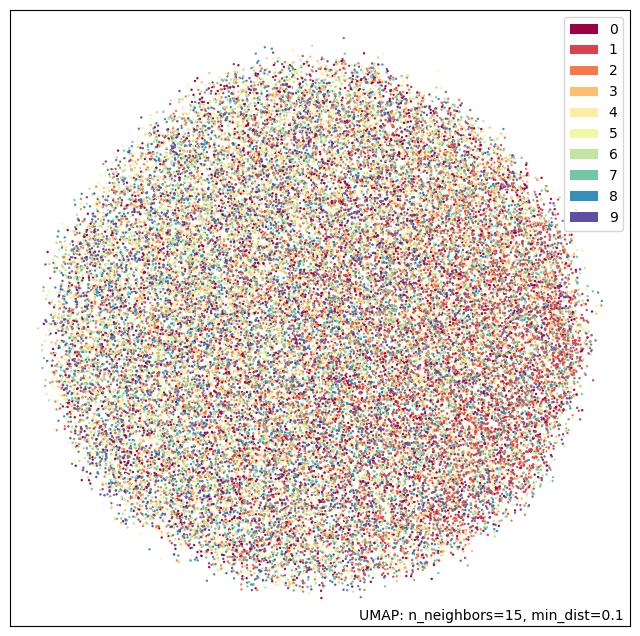

In [45]:
mapper = umap.UMAP(random_state = 42).fit(encoded_data)
umap.plot.points(mapper, labels = labels);

### contrastive Training over 100 Epochs

In [46]:
from IPython.display import Video
Video("contrastive_Training_100.mp4", height = 500, embed = True)